In [15]:
import numpy as np
import math
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def create_spatial_grid(stim_ecc, gridsize):
    """This function samples the visual space for a given eccentricity coverage and gridsize. 
    The x and y coordinate outputs arethen used for creating the pRF parameters (see create_prf_params function). 
    NMA is strictly implemented for a formulated space, so the model will only work 
    if the receptive fields are defined within the same grid as the input stimulus. """
    
    coord = np.sqrt(((stim_ecc)**2)/2)
    x_coordinates = np.linspace(-coord, coord, gridsize)
    y_coordinates = np.linspace(coord, -coord, gridsize)
    X, Y = np.meshgrid(x_coordinates, y_coordinates)
        
    return x_coordinates, y_coordinates, X, Y

In [3]:
def reshape_stimulus(stim, gridsize):
    
    # There does not seem to be a better way to resize a matrix image in Python. The following 
    # code snippet uses 1D interpolation across columns and rows separately, and resizes the original stimulus
    # input to the desired grid size 
    old_dim, new_dim = stim.shape[0], gridsize
    col_im = np.zeros((new_dim,old_dim))
    input_stim = np.zeros((new_dim,new_dim,stimorig.shape[2]))
    nls, ols = np.linspace(0, 1, new_dim), np.linspace(0,1,old_dim)

    for stimidx in range(0, stimorig.shape[2]):
        for col in range(old_dim):
            col_im[:,col] = np.interp(nls,ols,stimorig[:,col,stimidx])
        for col in range(new_dim):
            input_stim[col,:, stimidx] = np.interp(nls,ols,col_im[col,:])
        
    return input_stim

In [4]:
def create_prf_centers(x_coordinates, y_coordinates):
    
    prf_parameters = np.zeros((2,len(x_coordinates)*len(y_coordinates)))
    iter_idx = 0
    for i in range(0,len(y_coordinates)):
        for j in range(0,len(x_coordinates)):
            prf_parameters[0,iter_idx] = x_coordinates[j] 
            prf_parameters[1,iter_idx] = y_coordinates[i]
            #if sigmascaling == 'eccentric':
            #    prf_parameters[2,iter_idx] = 0.05 + 0.2*(np.sqrt(x_coordinates[i]**2 +  y_coordinates[j]**2)) # sigma
            #elif sigmascaling == 'convolutional':
            #    prf_parameters[2,iter_idx] = 0.05
            #prf_parameters[3,iter_idx] = 1 # assume uniform voxel gain for simplicity
            iter_idx = iter_idx + 1 

    return prf_parameters

In [89]:
def create_gaussian_field(x_grid, y_grid, x, y, sigma, type = None, normalize= True, flat = True):
    """Creates a 2D Gaussian for the given X and Y center and the sigma factor.
    Has the option to 1) normalize the Gaussian field to the unit volume and
    2) flatten the Gaussian (vectorize it)"""

    gaussian = np.exp(-((x_grid-x)**2 +(y_grid-y)**2)/(2*sigma)**2)

    if type == 'euclidean_distance':
        gaussian = np.exp(-np.sqrt(((x_grid-x)**2 +(y_grid-y)**2))/(2*sigma)**2)
    if normalize:
        gaussian = gaussian/np.linalg.norm(gaussian)
    if flat:
        gaussian = gaussian.flatten()

    return gaussian


In [60]:
def normalization_model(input_stim, stim_ecc, gridsize, lookup_prf_centers, voxeldata, rf_sigma_factor, attx0, atty0, attsd, attgain, suppWeight, summWeight, sigmaNorm):
    
    ##
    ###### preallocate #####
    lookup_prfs = np.zeros((gridsize*gridsize, gridsize*gridsize))
    stimdrive    = np.zeros((len(lookup_prf_centers[1]),len(input_stim[1,1,:])))
    numerator = np.zeros((len(lookup_prf_centers[1]),len(input_stim[1,1,:])))
    surroundresponse = np.zeros((len(lookup_prf_centers[1]),len(input_stim[1,1,:])))
    spsummedresponse = np.zeros((len(lookup_prf_centers[1]),len(input_stim[1,1,:])))
    predicted_response = np.zeros((voxeldata.shape[1],len(input_stim[1,1,:])))
    ###### preallocate #####
    ##
    
    flatten = lambda x: np.reshape(x, (gridsize*gridsize))
    
    # NMA: 
    
    
    # Instead of fitting a size to each pRF, we decided to optimize a slope to define pRF sizes within each ROI,
    # leveraging the linear relationship between pRF eccentricity and size:
    rf_sigma = 0.07 + rf_sigma_factor*(np.sqrt(lookup_prf_centers[0,:]**2 + lookup_prf_centers[1,:]**2))
    
    X, Y = create_spatial_grid(stim_ecc, gridsize)[2:4]
    
    # Simulate pRFs 
    for rf in range(0,lookup_prf_centers.shape[1]):
        lookup_prfs[:,rf] = flat_gaussian_field(X,Y,lookup_prf_centers[0,rf],lookup_prf_centers[1,rf],rf_sigma[rf], True)
        
    
    for stimidx in range(0,len(input_stim[1,1,:])):
        for rf in range(0,len(lookup_prfs[1])):
            RF = lookup_prfs[:,rf]
            stim = input_stim[:,:,stimidx]
            stim = flatten(stim)
            stimdrive[rf,stimidx] = np.dot(RF,stim)
            attweight = np.exp(-((attx0-lookup_prf_centers[0,rf])**2 +(atty0-lookup_prf_centers[1,rf])**2)/(2*attsd)**2)
            attweight = attgain*attweight+1
            numerator[rf,stimidx] = np.multiply(stimdrive[rf,stimidx],attweight)
            
        for rfsuppind in range(0,len(lookup_prfs[1])):
            rf_supp_sigma = rf_sigma[rfsuppind] * suppWeight
            distance = np.sqrt((X-lookup_prf_centers[0,rfsuppind])**2+(Y-lookup_prf_centers[1,rfsuppind])**2)           
            suppfield = np.exp(-.5*(distance/(rf_supp_sigma))**2)
            
            suppfield = suppfield / np.linalg.norm(suppfield)
            flatsurr = flatten(suppfield)
            
            surroundresponse[rfsuppind,stimidx] = np.dot(flatsurr,numerator[:,stimidx])
        print("Calculated the estimated response for stimulus %i of %i" %(stimidx, len(input_stim[1,1,:])))


    predneuralweights = numerator/(surroundresponse + sigmaNorm)

    for stimidx in range(0,len(input_stim[1,1,:])):
        for summidx in range(0,len(lookup_prfs[1])):
            rf_summ_sigma = rf_sigma[rfsuppind] * summWeight
            distance = np.sqrt((X-lookup_prf_centers[0,summidx])**2+(Y-lookup_prf_centers[1,summidx])**2);
            summfield = np.exp(-.5*(distance/(rf_summ_sigma))**2)
            
            summfield = summfield / np.linalg.norm(summfield)
            flatsumm = flatten(summfield)
            
            spsummedresponse[summidx,stimidx] = np.dot(flatsumm,predneuralweights[:,stimidx])
        print("Calculated the spatial summation for stimulus %i of %i" %(stimidx, len(input_stim[1,1,:])))

    #spsummedresponse = spsummedresponse / np.linalg.norm(summfield)
 
    for idx in range(0,voxeldata.shape[1]):
        distance_vector = np.sqrt((voxeldata[0, idx] - lookup_prf_centers[0,:])**2 + 
                                     (voxeldata[1, idx]- lookup_prf_centers[1,:])**2)
        closest_point_idx = np.argmin(np.abs(distance_vector))
        predicted_response[idx,:] = spsummedresponse[closest_point_idx,:]          
    
    return numerator, surroundresponse, predneuralweights, spsummedresponse, predicted_response

The model will first produce a predicted neural image for a population of neurons whose receptive fields tile the visual space perfectly. This is crucial because the calculation of a suppressive surround for each receptive field depends on what is surrounding that receptive field. Therefore, creating a look up table with the assumption that the visual space is indeed tiled perfectly (in spite of the imperfections of pRF estimates for certain locations in the visual field) we can estimate the responses of different voxels by finding a center location in the look up table that matches that voxel's center preference the best. This requires some changes in the model organization:

1) Create a visual field grid by sampling the space finely (at the moment 64x64, vista soft uses a 101x101 grid)

2) Simulate the responses of the pixelated RFs to 48 mapping stimulus locations under 4 attention locations (192 estimates of beta weights per RF)

3) Feed the voxel data to the model, for each voxel, match the preferred center to a location in the tiled responses by finding the minimum distance between a given voxel's center and various points in the tiled visual space

4) The output of the model will be a matrix in the size of N x 192 (N: number of voxels)

In [61]:
# load the stimulus
stimpath = '/Volumes/server/Projects/attentionpRF/Simulations/matlab_scripts/stimfiles'
stim_ecc = 10
gridsize = 64

stimtemp = scipy.io.loadmat(stimpath + '/stim.mat')
stimtemp = stimtemp['stim']
stimorig = stimtemp[:,:,0:48]

#### 



In [62]:
input_stim = reshape_stimulus(stimorig, gridsize)

In [63]:
x_coordinates, y_coordinates, X, Y = create_spatial_grid(stim_ecc, gridsize)

In [64]:
lookup_prf_centers = create_prf_centers(x_coordinates, y_coordinates)

In [65]:
# take a subset of pRFs that tile the diagonal axis of the visual field. This is
# to check how the suppressive surround differs when it is defined across a small subset of 
# pRFs 
synt_voxeldata = np.zeros((2, gridsize))

for k in range(0,gridsize):
    synt_voxeldata[:,k] = lookup_prf_centers[:,gridsize*k+k]


In [66]:
rf_sigma_factor = 0.05
attgain     = 4
attx0       = 0
atty0       = 5
attsd       = 1
sigmaNorm   = 0.01
suppWeight  = 3
summWeight  = 3

numerator, surroundresponse, predneuralweights, spsummedresponse, predicted_response = normalization_model(input_stim, stim_ecc, gridsize, lookup_prf_centers, synt_voxeldata, rf_sigma_factor, attx0, atty0, attsd, attgain, suppWeight, summWeight, sigmaNorm)

Calculated the estimated response for stimulus 0 of 48
Calculated the estimated response for stimulus 1 of 48
Calculated the estimated response for stimulus 2 of 48
Calculated the estimated response for stimulus 3 of 48
Calculated the estimated response for stimulus 4 of 48
Calculated the estimated response for stimulus 5 of 48
Calculated the estimated response for stimulus 6 of 48
Calculated the estimated response for stimulus 7 of 48
Calculated the estimated response for stimulus 8 of 48
Calculated the estimated response for stimulus 9 of 48
Calculated the estimated response for stimulus 10 of 48
Calculated the estimated response for stimulus 11 of 48
Calculated the estimated response for stimulus 12 of 48
Calculated the estimated response for stimulus 13 of 48
Calculated the estimated response for stimulus 14 of 48
Calculated the estimated response for stimulus 15 of 48
Calculated the estimated response for stimulus 16 of 48
Calculated the estimated response for stimulus 17 of 48
Ca

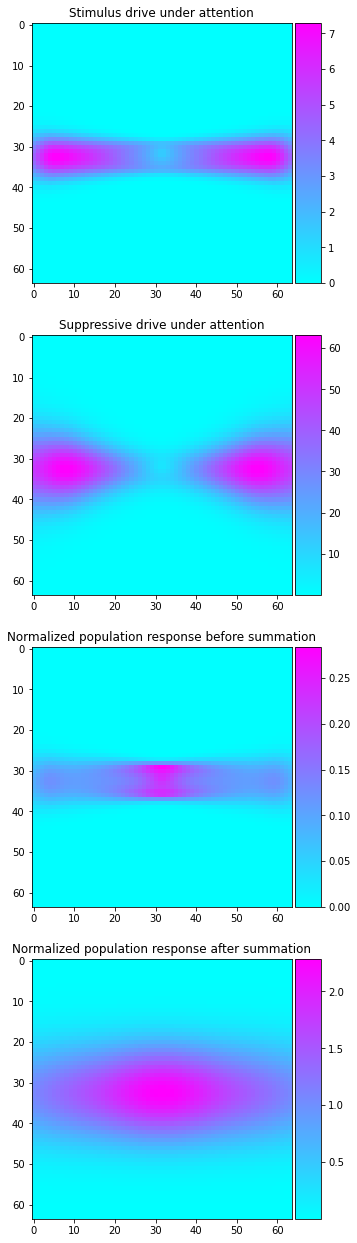

In [151]:
### VISUALIZE
stimidx = 36
numerator_toplot = np.reshape(numerator[:,stimidx],(gridsize,gridsize))
surroundresponse_toplot = np.reshape(surroundresponse[:,stimidx],(gridsize,gridsize))
neuralresponse_toplot = np.reshape(predneuralweights[:,stimidx],(gridsize,gridsize))
populationresponse_toplot = np.reshape(spsummedresponse[:,stimidx],(gridsize,gridsize))

colorm = 'cool'
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=[22,22])
im1 = ax1.imshow(numerator_toplot, cmap = colorm)
ax1.set_title('Stimulus drive under attention')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="10%", pad=0.05)
cbar4 = plt.colorbar(im1, cax=cax1)

im2 = ax2.imshow(surroundresponse_toplot, cmap = colorm)
ax2.set_title('Suppressive drive under attention')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="10%", pad=0.05)
cbar4 = plt.colorbar(im2, cax=cax2)

im3 = ax3.imshow(neuralresponse_toplot ,cmap = colorm)
ax3.set_title('Normalized population response before summation')
divider = make_axes_locatable(ax3)
cax3 = divider.append_axes("right", size="10%", pad=0.05)
cbar4 = plt.colorbar(im3, cax=cax3)

im4 = ax4.imshow(populationresponse_toplot,cmap = colorm)
ax4.set_title('Normalized population response after summation');
divider = make_axes_locatable(ax4)
cax4 = divider.append_axes("right", size="10%", pad=0.05)
cbar4 = plt.colorbar(im4, cax=cax4)

In [84]:
A = torch.rand(4096,4096)

In [85]:
B = torch.rand(4096,48)
#surroundresponse[rfsuppind,stimidx] = np.dot(flatsurr,numerator[:,stimidx])
arr_dotprod = torch.empty((4096, 48))
for stimidx in range(0,48):
    for rfidx in range(0,4096):
        arr_dotprod[rfidx,stimidx] = torch.dot(A[:,rfidx],B[:,stimidx])
arr_ein = torch.einsum('wi,ik->wk', A.T, B)

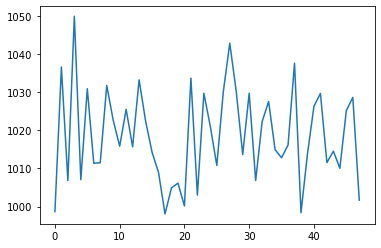

In [86]:
plt.plot(arr_ein[1,:])

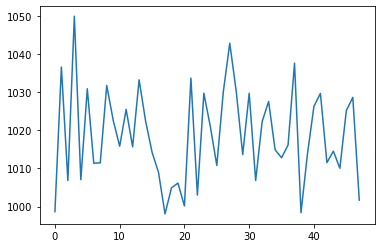

In [87]:
plt.plot(arr_dotprod[1,:])

In [13]:
spsummedresponse_image = np.reshape(spsummedresponse, (gridsize, gridsize, spsummedresponse.shape[1]))
predneuralweights_image = np.reshape(predneuralweights, (gridsize, gridsize, predneuralweights.shape[1]))
simulated_surround_img = np.reshape(surroundresponse, (gridsize, gridsize, predneuralweights.shape[1]))
numImg = np.reshape(numerator, (gridsize, gridsize, predneuralweights.shape[1]))
#predicted_response_img = np.reshape(predicted_response, (gridsize, gridsize, predneuralweights.shape[1]))

clim = [0, 30]
@widgets.interact(stimuluslocation=widgets.IntSlider(min=0, max=predneuralweights_image.shape[2]-1, step=1, value=0))
def plot_populationresponse(stimuluslocation):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,10])
    ax1.imshow(numImg[:,:,stimuluslocation], clim = clim, cmap='Blues')
    ax1.set_title('numerator')
    ax2.imshow(simulated_surround_img[:,:,stimuluslocation],clim = clim,cmap='Blues')
    ax2.set_title('suppressive drive')

interactive(children=(IntSlider(value=0, description='stimuluslocation', max=47), Output()), _dom_classes=('wi…

In [21]:
# visualize
clim2 = [0, 2]

@widgets.interact(stimuluslocation=widgets.IntSlider(min=0, max=predneuralweights_image.shape[2]-1, step=1, value=0))
def plot_populationresponse(stimuluslocation):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10,10])
    ax1.imshow(predneuralweights_image[:,:,stimuluslocation], clim = clim2, cmap='Blues')
    ax1.set_title('Predicted neural responses before summation')
    ax2.imshow(spsummedresponse_image[:,:,stimuluslocation],  clim = clim2,cmap='Blues')
    ax2.set_title('Predicted neural responses after summation')


interactive(children=(IntSlider(value=0, description='stimuluslocation', max=47), Output()), _dom_classes=('wi…

In [22]:
@widgets.interact(rf=widgets.IntSlider(min=109, max=predneuralweights.shape[0]-1, step=1, value=0))
def plot_populationresponse(rf):
    plt.plot(predneuralweights[rf,:])
    plt.plot(spsummedresponse[rf,:])
    plt.legend(['before summation', 'after summation'])



interactive(children=(IntSlider(value=109, description='rf', max=1023, min=109), Output()), _dom_classes=('wid…

In [20]:
# Save the simulated data and pRF centers
np.save('predicted_response', predicted_response, allow_pickle=True, fix_imports=True)
np.save('simulated_prf_centers', synt_voxeldata, allow_pickle=True, fix_imports=True)




In [77]:
lookup_prf_centers

(2, 4096)

In [125]:
rfids = np.arange(0, 64*64)
gaussian_supp = np.empty((64*64, len(rfids)))
gaussian_rf = np.empty((64, 64, len(rfids)))

for i, rf in enumerate(rfids):
    gaussian_rf[...,i] =  create_gaussian_field(X, Y, lookup_prf_centers[0, rf], lookup_prf_centers[1,rf], 1, 'euclidean_distance', True,False)
    gaussian_supp[...,i] = create_gaussian_field(X, Y, lookup_prf_centers[0, rf], lookup_prf_centers[1,rf], 2, 'euclidean_distance', True,True)

In [135]:
numerator_dotprod = np.empty(len(rfids))
for i in range(0,len(rfids)):
    numerator_dotprod[i] = np.dot(np.reshape(gaussian_rf[:,:,i], (64*64)), np.reshape(input_stim[:,:,12], (64*64)))
print(numerator_dotprod)

[3.68583006 3.73390046 3.79393853 ... 4.15459133 4.09148356 4.04129179]


In [137]:
response = np.empty(len(rfids))
for i in range(0,len(rfids)):
    response[i] = np.dot(gaussian_supp[:,i],numerator_dotprod)
print(response)

[413.37533575 413.60193824 413.86854674 ... 418.42401177 418.22999267
 418.07176397]


In [141]:
response_einsum = np.einsum('wi,ik->wk', gaussian_supp.T, numerator_einsum)
print(response_einsum[:,12])

[413.37533575 413.60193824 413.86854674 ... 418.42401177 418.22999267
 418.07176397]


In [128]:
numerator_einsum = np.einsum('ijk,ija->ka', gaussian_rf, input_stim)

In [142]:
response_einsum.shape

(4096, 48)

In [129]:
numerator_einsum.shape

(4096, 48)

In [133]:
numerator_dotprod

array([3.68583006e+00, 3.73390046e+00, 3.79393853e+00, ...,
       3.86592014e-03, 2.24903574e-03, 1.27584428e-03])

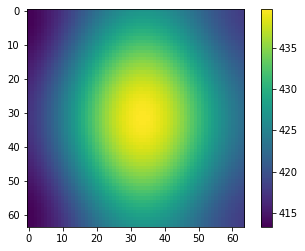

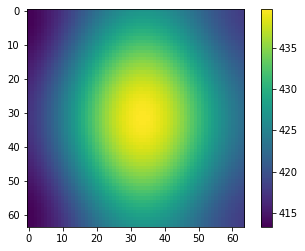

In [149]:
plt.figure()
plt.imshow(np.reshape(response, (64,64)))
plt.colorbar()
plt.figure()
plt.imshow(np.reshape(response_einsum[:,12], (64,64)))
plt.colorbar()


In [147]:
response_einsum.shape

(4096, 48)